In [ ]:
from flask import Flask, render_template, request, jsonify
import numpy as np
from PIL import Image
import tensorflow as tf
import numpy as np
import os
import os
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
import cv2
import numpy as np
import joblib
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
import sklearn

In [ ]:
errorMessage = None
model = None

try:
    model_path = '/content/Classifer_Using_Thresholding_and_Decision_Tree__For_2_Images (1).plk'
    classifier_model = joblib.load(model_path)
    print("Classifier model loaded successfully!")
except Exception as e:
    errorMessage = e
    model = None

Classifier model loaded successfully!


In [ ]:
def strideImage(image):
    startx, starty = 300, 350
    endx, endy = 1100, 1150
    cropped_image = image[starty:endy, startx:endx]

    image = cropped_image
    height, width, _ = image.shape

    grid_size = 6

    box_width = width // grid_size
    box_height = height // grid_size

    grid_boxes = []

    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            x_start = j * box_width
            y_start = i * box_height
            x_end = x_start + box_width
            y_end = y_start + box_height
            row.append(image[y_start:y_end, x_start:x_end])
        grid_boxes.append(row)

    def sliding_window(grid_boxes, grid_size, window_size):
        stride = 1
        boxes = []
        for i in range(0, grid_size - window_size + 1, stride):
            for j in range(0, grid_size - window_size + 1, stride):
                sub_grid = [grid_boxes[i+k][j:j+window_size] for k in range(window_size)]
                sub_image = np.vstack([np.hstack(row) for row in sub_grid])

                boxes.append(sub_image)

        return boxes

    boxes_2x2 = sliding_window(grid_boxes, grid_size=6, window_size=2)
    boxes_3x3 = sliding_window(grid_boxes, grid_size=6, window_size=2)
    return boxes_2x2, boxes_3x3

In [ ]:
def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    return cv2.resize(image, (64, 64)) if image is not None else None

def calculate_white_pixel_ratio(gray_image):
    _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
    white_pixel_count = np.sum(thresholded_image == 255)
    return white_pixel_count / thresholded_image.size

def extract_node_features(image):
    segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
    node_features = []
    for region_id in np.unique(segments):
        mask = segments == region_id
        if mask.sum() == 0:
            continue

        props = regionprops(mask.astype(int), intensity_image=rgb2gray(image))
        if props:
            node_features.append(extract_region_features(image, mask, props[0]))
    return node_features

def extract_region_features(image, mask, region_props):
    mean_color = np.mean(image[mask], axis=0)
    area, perimeter = region_props.area, region_props.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    colorfulness = np.sqrt((mean_color[0] - mean_color[1]) ** 2 + (0.5 * (mean_color[0] + mean_color[1]) - mean_color[2]) ** 2)

    # LBP histogram
    lbp = local_binary_pattern(rgb2gray(image), P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp[mask], bins=np.arange(0, 11), density=True)

    centroid = region_props.centroid
    return [centroid[0] / image.shape[0], centroid[1] / image.shape[1], *mean_color, area, perimeter, circularity, colorfulness, *lbp_hist]


In [ ]:
def predicttt(image, classifier):

    if image is None:
        print("Image not found.")
        return None

    feature_vector = process_image(image)
    if feature_vector is None:
        print("No features extracted.")
        return None


    prediction = classifier.predict([feature_vector])[0]
    probability = classifier.predict_proba([feature_vector])[0][prediction]
    class_label = "Cyclone" if prediction == 0 else "Non-Cyclone"

    return class_label, probability

In [ ]:
import os
import cv2
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage.measure import regionprops
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

def load_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    return cv2.resize(image, (64, 64)) if image is not None else None

def calculate_white_pixel_ratio(gray_image):
    _, thresholded_image = cv2.threshold((gray_image * 255).astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
    white_pixel_count = np.sum(thresholded_image == 255)
    return white_pixel_count / thresholded_image.size

def extract_node_features(image):
    segments = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
    node_features = []
    for region_id in np.unique(segments):
        mask = segments == region_id
        if mask.sum() == 0:
            continue

        props = regionprops(mask.astype(int), intensity_image=rgb2gray(image))
        if props:
            node_features.append(extract_region_features(image, mask, props[0]))
    return node_features

def extract_region_features(image, mask, region_props):
    mean_color = np.mean(image[mask], axis=0)
    area, perimeter = region_props.area, region_props.perimeter
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    colorfulness = np.sqrt((mean_color[0] - mean_color[1]) ** 2 + (0.5 * (mean_color[0] + mean_color[1]) - mean_color[2]) ** 2)

    # LBP histogram
    lbp = local_binary_pattern(rgb2gray(image), P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp[mask], bins=np.arange(0, 11), density=True)

    centroid = region_props.centroid
    return [centroid[0] / image.shape[0], centroid[1] / image.shape[1], *mean_color, area, perimeter, circularity, colorfulness, *lbp_hist]

def process_image(image):
    gray_image = rgb2gray(image)
    white_pixel_ratio = calculate_white_pixel_ratio(gray_image)
    node_features = extract_node_features(image)


    if node_features:
        return np.mean(node_features, axis=0).tolist() + [white_pixel_ratio]
    return None

def predict_class(img_path, classifier):
    image = load_image(img_path)

    if image is None:
        print("Image not found.")
        return None

    feature_vector = process_image(image)
    if feature_vector is None:
        print("No features extracted.")
        return None


    prediction = classifier.predict([feature_vector])[0]
    probability = classifier.predict_proba([feature_vector])[0][prediction]
    class_label = "Cyclone" if prediction == 0 else "Non-Cyclone"
    print(f"Prediction: {class_label}, Probability: {probability:.2f}")

    # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.title(f"Prediction: {class_label}, Probability: {probability:.2f}")
    # plt.show()

    return class_label, probability


In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow

def predict():
    img = cv2.imread('/content/cyclone_2.jpg')
    import joblib
    model_path = '/content/drive/MyDrive/Cyclone_Intensity_Estimation/Classifer_Using_Thresholding_and_Decision_Tree_2.plk'
    model = joblib.load(model_path)

    # Now you can pass `img` to your `strideImage` function
    strides1, strides2 = strideImage(img)
    flag = 0
    cyclones=[]
    for i, box in enumerate(strides1):
        cv2.imwrite("/content/temp.jpg",box)
        # Save each image to the folder
        # save_path = os.path.join(output_folder, f'image_{50+i}.jpg')
        # cv2.imwrite(save_path, box)
        # print(f'Saved {save_path}')
        curClass = predict_class('/content/temp.jpg', model)
        cv2_imshow(box)

        print(curClass)


        if curClass[0] == 'Cyclone':
            flag = 1
            cyclones.append(box)


    if flag == 1:
        print("Cyclone Detected")
        for i in cyclones:
            cv2_imshow(i)
    else:
        print("No Cyclone Detected")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prediction: Non-Cyclone, Probability: 1.00


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


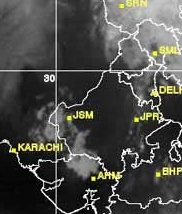

('Non-Cyclone', 1.0)
Prediction: Non-Cyclone, Probability: 0.99


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


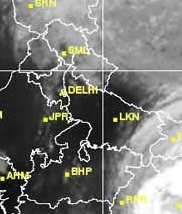

('Non-Cyclone', 0.99)
Prediction: Non-Cyclone, Probability: 0.95


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


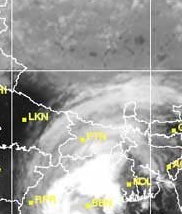

('Non-Cyclone', 0.95)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.92


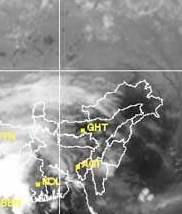

('Non-Cyclone', 0.92)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.99


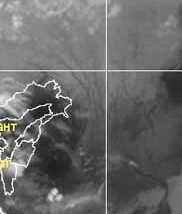

('Non-Cyclone', 0.99)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.99


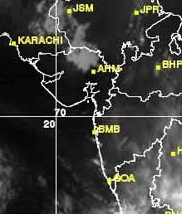

('Non-Cyclone', 0.99)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.94


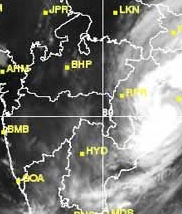

('Non-Cyclone', 0.94)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Cyclone, Probability: 0.87


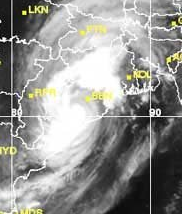

('Cyclone', 0.87)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.97


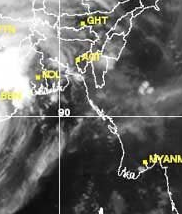

('Non-Cyclone', 0.97)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.99


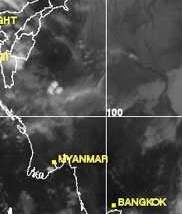

('Non-Cyclone', 0.99)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.96


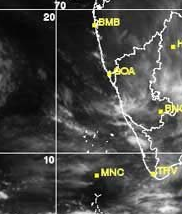

('Non-Cyclone', 0.96)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.96


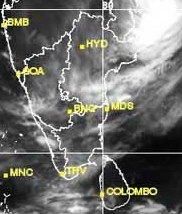

('Non-Cyclone', 0.96)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.90


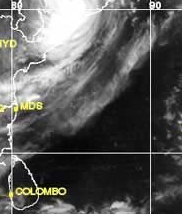

('Non-Cyclone', 0.9)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.98


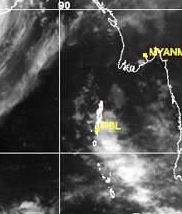

('Non-Cyclone', 0.98)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.99


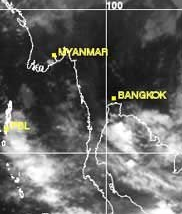

('Non-Cyclone', 0.99)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.99


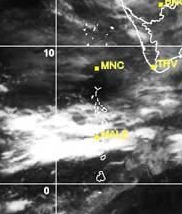

('Non-Cyclone', 0.99)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.99


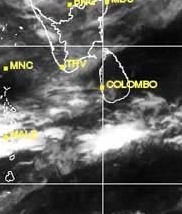

('Non-Cyclone', 0.99)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.97


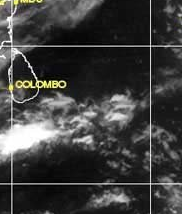

('Non-Cyclone', 0.97)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.99


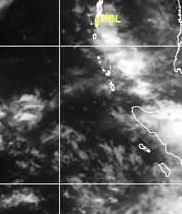

('Non-Cyclone', 0.99)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.92


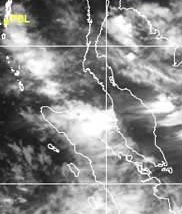

('Non-Cyclone', 0.92)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.92


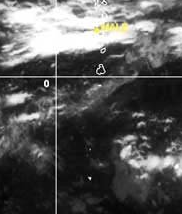

('Non-Cyclone', 0.92)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.90


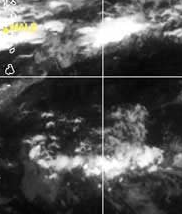

('Non-Cyclone', 0.9)
Prediction: Non-Cyclone, Probability: 0.92


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


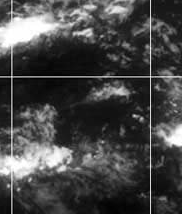

('Non-Cyclone', 0.92)
Prediction: Non-Cyclone, Probability: 0.96


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


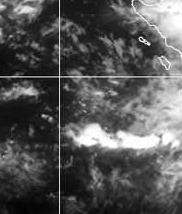

('Non-Cyclone', 0.96)


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Prediction: Non-Cyclone, Probability: 0.95


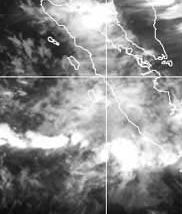

('Non-Cyclone', 0.95)
Cyclone Detected


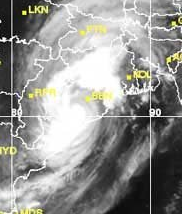

In [ ]:
predict()

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


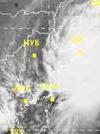

('Cyclone', 0.93)
Cyclone Detected


In [ ]:
predict()